### Example loop extrusion simulation - 1D/Trajectory component

In [30]:
########## 
# Define functions needed for calculating trajectories
##########

import numpy as np
import pandas as pd
import h5py 
import matplotlib.pyplot as plt

class leg(object):
    def __init__(self, pos, attrs={"stalled":False, "CTCF":False}):
        """
        A leg has two important attribues: pos (positions) and attrs (a custom list of attributes)
        Represents one side of the cohesin
        """
        self.pos = pos
        self.attrs = dict(attrs)

class cohesin(object):
    """
    A cohesin class provides fast access to attributes and positions 
    
    
    cohesin.left is a left leg of cohesin, cohesin.right is a right leg
    cohesin[-1] is also a left leg and cohesin[1] is a right leg         
    
    Also, cohesin.any("myattr") is True if myattr==True in at least one leg
    cohesin.all("myattr") is if myattr=True in both legs
    """
    def __init__(self, leg1, leg2):
        self.left = leg1 # Left position on the polymer that the cohesin is contacting
        self.right = leg2 # Right position on the polymer that the cohesin is contacting
   
    def any(self, attr): # Is attr true for either leg?
        return self.left.attrs[attr] or self.right.attrs[attr]
    
    def all(self, attr): # Is attr true for both legs?
        return self.left.attrs[attr] and self.right.attrs[attr]    
    
    def __getitem__(self, item): # Method so that we can index the object via []
        if item == -1:
            return self.left
        elif item == 1:
            return self.right 
        else:
            raise ValueError()
        

def unloadProb(cohesin, args):
    """
    Defines unload probability based on a state of cohesin 
    """
    if cohesin.any("stalled"):
        # if one side is stalled, we have different unloading probability 
        # Note that here we define stalled cohesins as those stalled not at CTCFs 
        return 1 / args["LIFETIME_STALLED"]
    # otherwise we are just simply unloading 
    return 1 / args["LIFETIME"]    
    


def loadOne(cohesins, occupied, args): 
    """
    A function to load one cohesin 
    """
    while True:
        a = np.random.randint(args["N"]) # Candidate spot for cohesin loading
        if (occupied[a] == 0) and (occupied[a+1] == 0): # Both the target spot and the next spot must be unoccupied 
            occupied[a] = 1 # Spot occupied by cohesin
            occupied[a+1] = 1 # Next spot also occupied by cohesin
            print('Loading cohesin at left leg = {}, right leg = {}'.format(a, a+1))
            cohesins.append(cohesin(leg(a), leg(a+1))) # Append cohesin OBJECT to list
            break


def capture(cohesin, occupied, args):
    """
    We are describing CTCF capture here. 
    This function is specific to this particular project, and 
    users are encouraged to write functions like this 
    
    Note the for-loop over left/right sites below, and using cohesin[side] 
    to get left/right leg. 
    
    Also note how I made ctcfCapture a dict with -1 coding for left side, and 1 for right side 
    and ctcfCapture are dicts as well: keys are locations, and values are probabilities of capture
    """    
    for side in [1, -1]:
        # get probability of capture or otherwise it is 0 
        if np.random.random() < args["ctcfCapture"][side].get(cohesin[side].pos, 0):  
            if side==-1:
                print('Cohesin left leg at pos {} captured by CTCF'.format(cohesin.left.pos))
            if side==1:
                print('Cohesin right leg at pos {} captured by CTCF'.format(cohesin.right.pos))
            cohesin[side].attrs["CTCF"] = True  # captured a cohesin at CTCF     
    return cohesin 


def release(cohesin, occupied, args):
    
    """
    AN opposite to capture - releasing cohesins from CTCF 
    """
    
    if not cohesin.any("CTCF"):
        return cohesin  # no CTCF: no release necessary 
        
    # attempting to release either side 
    for side in [-1, 1]: 
        # Check if probability (rand) is less than the CTCF release prob. for the current side (-1 or 1)
        if (np.random.random() < args["ctcfRelease"][side].get(cohesin[side].pos, 0)) and (cohesin[side].attrs["CTCF"]):
            if side==-1:
                print('Cohesin left leg at pos {} released by CTCF'.format(cohesin.left.pos))
            if side==1:
                print('Cohesin right leg at pos {} released by CTCF'.format(cohesin.left.pos))
            cohesin[side].attrs["CTCF"] = False # CTCF is released, thus set the current cohesin leg's CTCF attribute to False
    return cohesin 


def translocate(cohesins, occupied, args):
    """
    This function describes everything that happens with cohesins - 
    loading/unloading them and stalling against each other 
    
    It relies on the functions defined above: unload probability, capture/release. 
    """
    # first we try to unload cohesins and free the matching occupied sites 
    for i in range(len(cohesins)):
        prob = unloadProb(cohesins[i], args) # Get the unloading probability for this cohesin
        if np.random.random() < prob: # Does cohesin get unloaded?
            print('Cohesin unloaded -- left leg: {}, right leg: {}'.format(cohesins[i].left.pos, cohesins[i].right.pos))
            occupied[cohesins[i].left.pos] = 0 # Unload left leg of cohesin
            occupied[cohesins[i].right.pos] = 0 # Unload right leg of cohesin
            del cohesins[i] # Remove the old cohesin object
            loadOne(cohesins, occupied, args) # load new cohesin at new spot
    
    # then we try to capture and release them by CTCF sites 
    for i in range(len(cohesins)): # For all cohesins, try to capture / release from CTCF
        cohesins[i] = capture(cohesins[i], occupied, args) # Capture
        cohesins[i] = release(cohesins[i], occupied, args) # Release
    
    # finally we translocate, and mark stalled cohesins because 
    # the unloadProb needs this 
    for i in range(len(cohesins)):
        cohesin = cohesins[i] 
        for leg in [-1,1]: 
            if not cohesin[leg].attrs["CTCF"]: # If this leg of this cohesin is not CTCF-bound
                # cohesins that are not at CTCFs and cannot move are labeled as stalled 
                if occupied[cohesin[leg].pos  + leg] != 0: # If the cohesin cannot move 
                    print('Cohesin leg at pos {} stalled'.format(cohesin[leg].pos))
                    cohesin[leg].attrs["stalled"] = True
                else:
                    cohesin[leg].attrs["stalled"] = False 
                    print('Cohesin leg at pos {} translocating'.format(cohesin[leg].pos))
                    occupied[cohesin[leg].pos] = 0 # Mark this leg as unoccupied
                    occupied[cohesin[leg].pos + leg] = 1 # Mark other leg as occupied - 'moves' the cohesin 
                    cohesin[leg].pos += leg # Update the position of the cohesin leg        
        cohesins[i] = cohesin # Reassign cohesin object to cohesin list
        
def color(cohesins, args):
    "A helper function that converts a list of cohesins to an array colored by cohesin state"    
    def state(attrs):
        if attrs["stalled"]:
            return 2
        if attrs["CTCF"]:
            return 3
        return 1
    ar = np.zeros(args["N"])
    for i in cohesins:
        ar[i.left.pos] = state(i.left.attrs)
        ar[i.right.pos] = state(i.right.attrs)  
    return ar 

In [38]:
SMCs = 1
args = {}
N = 500

ctcfLeftCapture = {100:0.75}  # at position 50 we have a CTCF that  travelling left with 50% prob
ctcfRightCapture = {400:0.75}  # and at 150 - those travelling right 
ctcfLeftRelease = {100:0.02}     # and we release them with 0.02 probability each step (on average 50 step residence time)
ctcfRightRelease = {400:0.02}  

args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}  # this is how we feed the dictionaries of capture/release probabilities to our code 
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = 100
args["LIFETIME_STALLED"] = 10 # in this code, if you are stalled, you have 10 times lower lifetime 
# but if you are stalled at CTCF, you don't 
# try to find this in the image below and verify that it works

occupied = np.zeros(N) # Is position n occupied? 1 = yes, 0 = no
occupied[0] = 1 # Position 0 is occupied 
occupied[-1] = 1 # Position N is occupied, i think making the ends of the polymer occupied ensures that none of our factors 'fall off' of the polymer? 
cohesins = [] # Current location of cohesins

# For 1:# SMCs, load the cohesin onto the polymer
for i in range(SMCs): 
    print('Loading initial cohesin #{}'.format(i+1))
    loadOne(cohesins, occupied, args)

pos = []
for i in range(300):
    for _ in range(3):
        translocate(cohesins, occupied, args)
    pos.append(color(cohesins, args))

Loading initial cohesin #1
Loading cohesin at left leg = 250, right leg = 251
Cohesin leg at pos 250 translocating
Cohesin leg at pos 251 translocating
Cohesin leg at pos 249 translocating
Cohesin leg at pos 252 translocating
Cohesin leg at pos 248 translocating
Cohesin leg at pos 253 translocating
Cohesin leg at pos 247 translocating
Cohesin leg at pos 254 translocating
Cohesin leg at pos 246 translocating
Cohesin leg at pos 255 translocating
Cohesin leg at pos 245 translocating
Cohesin leg at pos 256 translocating
Cohesin leg at pos 244 translocating
Cohesin leg at pos 257 translocating
Cohesin leg at pos 243 translocating
Cohesin leg at pos 258 translocating
Cohesin leg at pos 242 translocating
Cohesin leg at pos 259 translocating
Cohesin leg at pos 241 translocating
Cohesin leg at pos 260 translocating
Cohesin leg at pos 240 translocating
Cohesin leg at pos 261 translocating
Cohesin leg at pos 239 translocating
Cohesin leg at pos 262 translocating
Cohesin leg at pos 238 translocati

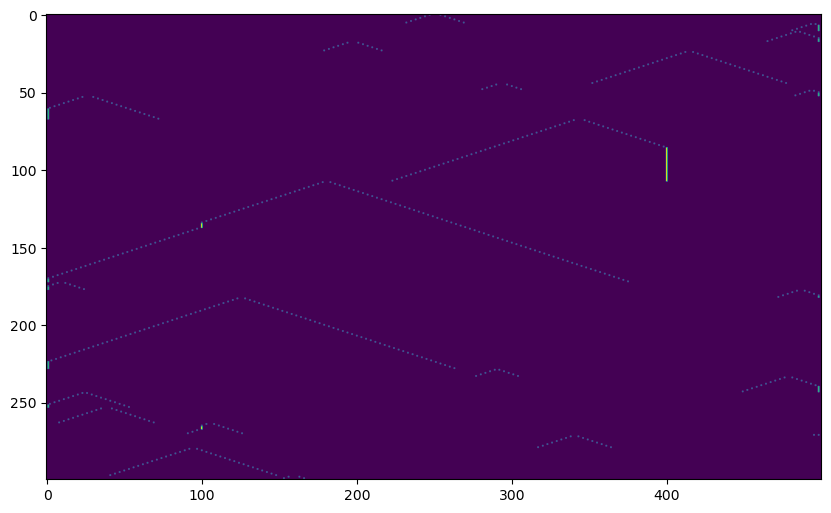

In [39]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.array(pos))